<a href="https://colab.research.google.com/github/MateusBrunozi/PricePredictionPcComponentsEDA/blob/main/Predi%C3%A7%C3%A3oDePre%C3%A7oDeComponentesEDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
# ======================================================
# 1. Importação das Bibliotecas
# ======================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
sns.set(style="whitegrid", palette="muted")

print("Bibliotecas importadas com sucesso!")

Bibliotecas importadas com sucesso!


In [15]:
# ======================================================
# 2. Carregamento e Combinação dos Dados (do Google Drive)
# ======================================================


from google.colab import drive


!git clone https://github.com/MateusBrunozi/PricePredictionPcComponentsEDA.git

NOME_REPOSITORIO = "PricePredictionPcComponentsEDA"


path = f"/content/{NOME_REPOSITORIO}/DataSetPcComponents"

print(f"Procurando arquivos CSV em: {path}")

files = glob.glob(os.path.join(path, "*.csv"))

if not files:
    print(f"ERRO: Nenhum arquivo .csv encontrado no diretório: {path}")
else:
    print(f"Encontrados {len(files)} arquivos CSV.")

dfs = []

for file in files:
    try:
        df_temp = pd.read_csv(file)

        category_name = os.path.basename(file).replace(".csv", "")
        df_temp["Category"] = category_name

        dfs.append(df_temp)
        print(f"  - Lendo {os.path.basename(file)} ({df_temp.shape[0]} linhas)")

    except Exception as e:
        print(f"Erro ao ler {file}: {e}")

if dfs:
    df = pd.concat(dfs, ignore_index=True)
    print(f"\nDataset combinado com sucesso!")
    print(f"Formato total: {df.shape[0]} linhas | {df.shape[1]} colunas")
    df.head()
else:
    print("Nenhum dado foi carregado. O DataFrame está vazio.")

fatal: destination path 'PricePredictionPcComponentsEDA' already exists and is not an empty directory.
Procurando arquivos CSV em: /content/PricePredictionPcComponentsEDA/DataSetPcComponents
Encontrados 7 arquivos CSV.
  - Lendo RAM.csv (1440 linhas)
  - Lendo MotherBoard.csv (1440 linhas)
  - Lendo StorageSSD.csv (2640 linhas)
  - Lendo CPU.csv (1440 linhas)
  - Lendo cabinates.csv (3120 linhas)
  - Lendo PowerSupply.csv (1120 linhas)
  - Lendo GPU.csv (600 linhas)

Dataset combinado com sucesso!
Formato total: 11800 linhas | 10 colunas


In [16]:
# ======================================================
# 3. Limpeza da Variável Alvo (Preço)
# ======================================================

# Definir a taxa de conversão.

TAXA_CONVERSAO_BRL = 16.3

if 'MRP' not in df.columns:
    print("ERRO: Coluna 'MRP' não encontrada. Verificando colunas disponíveis:")
    print(df.columns)
else:
    print("Iniciando limpeza da coluna 'MRP'...")

    df['MRP_cleaned'] = df['MRP'].astype(str).replace('[^0-9.]', '', regex=True)

    # 2. Converter para número (float). 'coerce' transforma erros em NaT/NaN
    df['MRP_cleaned'] = pd.to_numeric(df['MRP_cleaned'], errors='coerce')

    # 3. Remover linhas onde o preço é nulo (NaN) ou zero (não servem para prever)
    df.dropna(subset=['MRP_cleaned'], inplace=True)
    df = df[df['MRP_cleaned'] > 0]


    # Renomear para 'Price_INR' (Preço em Rúpias Indianas)
    df.rename(columns={'MRP_cleaned': 'Price_INR'}, inplace=True)

    # Criar a coluna 'Price_BRL' (Preço em Reais) para análise
    df['Price_BRL'] = df['Price_INR'] / TAXA_CONVERSAO_BRL

    # Criar a coluna 'Price_BRL_log' (Log do Preço)
    # Modelos lineares funcionam muito melhor com distribuições normais
    # Aplicar Log(x+1) corrige a assimetria (skew) dos dados de preço
    df['Price_BRL_log'] = np.log1p(df['Price_BRL'])

    print("Limpeza de preço concluída.")
    print("Colunas de preço criadas: 'Price_INR', 'Price_BRL', 'Price_BRL_log'")

    # Mostrar estatísticas das novas colunas de preço
    print(df[['Price_INR', 'Price_BRL', 'Price_BRL_log']].describe())

Iniciando limpeza da coluna 'MRP'...
Limpeza de preço concluída.
Colunas de preço criadas: 'Price_INR', 'Price_BRL', 'Price_BRL_log'
       Price_INR  Price_BRL  Price_BRL_log
count   11797.00   11797.00       11797.00
mean     7859.39     482.17           5.24
std     16489.39    1011.62           1.26
min       129.00       7.91           2.19
25%      1499.00      91.96           4.53
50%      2325.00     142.64           4.97
75%      6819.00     418.34           6.04
max    207999.00   12760.67           9.45


--- Iniciando Análise Exploratória (EDA) ---

Informações Gerais do DataFrame:
<class 'pandas.core.frame.DataFrame'>
Index: 11797 entries, 0 to 11799
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     7557 non-null   float64
 1   Ram            1437 non-null   object 
 2   MRP            11797 non-null  object 
 3   Category       11797 non-null  object 
 4   motherBoard    1440 non-null   object 
 5   SSD            2640 non-null   object 
 6   CPU            1440 non-null   object 
 7   cabinates      3120 non-null   object 
 8   PowerSupply    1120 non-null   object 
 9   GPU            600 non-null    object 
 10  Price_INR      11797 non-null  float64
 11  Price_BRL      11797 non-null  float64
 12  Price_BRL_log  11797 non-null  float64
dtypes: float64(4), object(9)
memory usage: 1.3+ MB

Top 20 colunas com mais valores ausentes:
GPU              11197
PowerSupply      10677
Ram             

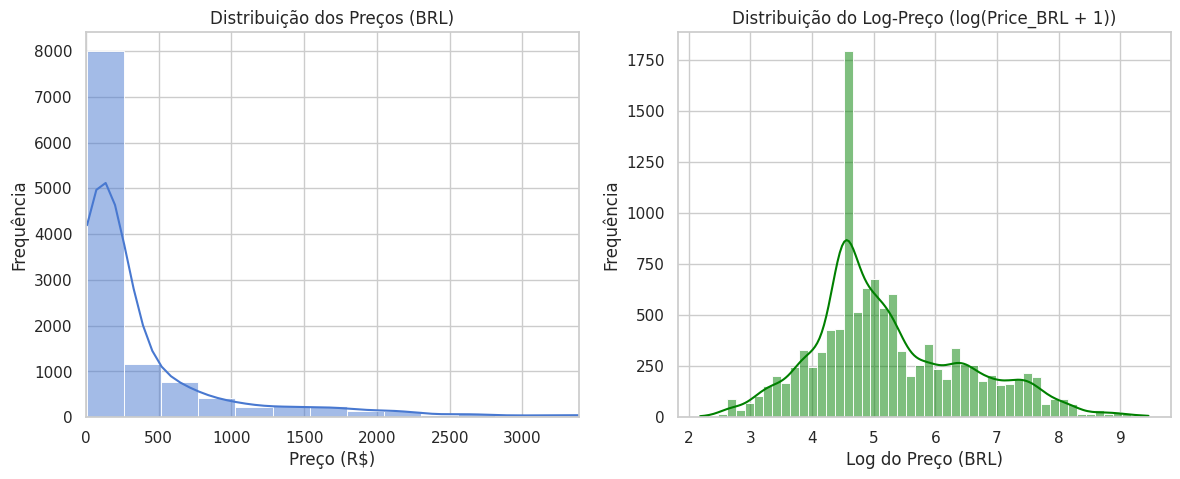

Observação: O gráfico da esquerda é 'assimétrico à direita'.
O gráfico da direita (Log) é muito mais 'normal', o que é ideal para Regressão Linear.


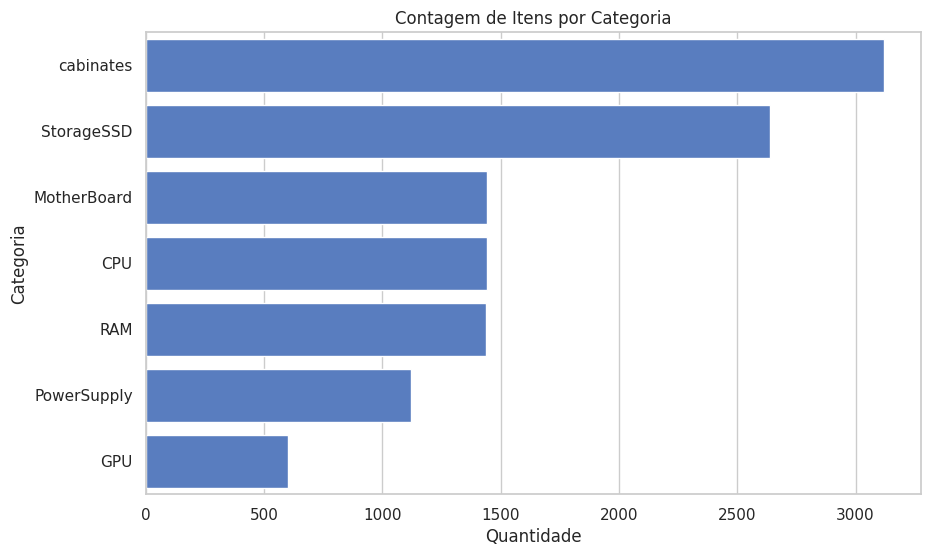

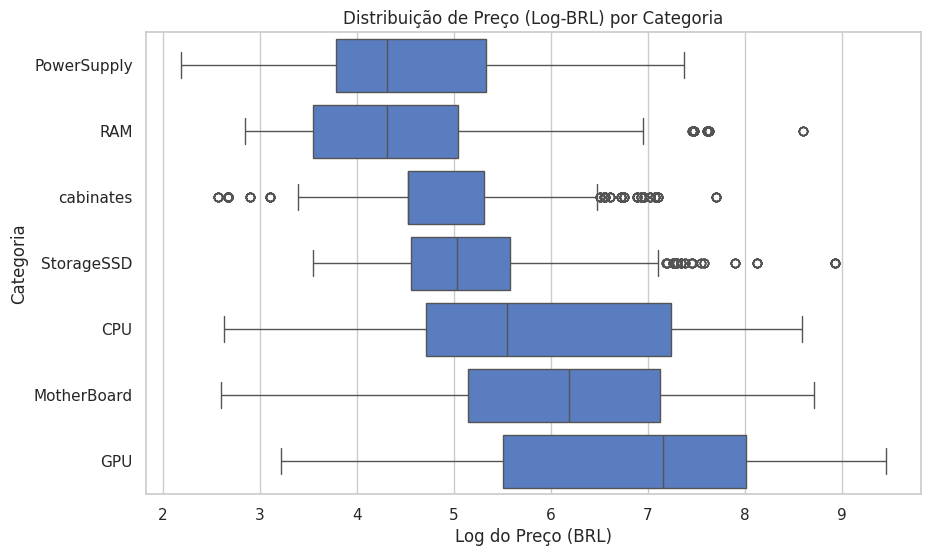


--- Análise de Cardinalidade ---
Valores únicos por coluna de texto (Top 20):
SSD            380
cabinates      378
Ram            315
motherBoard    305
CPU            279
PowerSupply    260
GPU            190
Category         7
dtype: int64

ALERTA DE ALTA CARDINALIDADE:
Colunas como 'Name', 'Model' e 'Link' têm milhares de valores únicos.
Elas são identificadores e não devem ser usadas para treino (serão removidas).


In [17]:
# ======================================================
# 4. Análise Exploratória de Dados (EDA)
# ======================================================

print("--- Iniciando Análise Exploratória (EDA) ---")

# --- 4.1 Informações Gerais e Valores Ausentes ---
print("\nInformações Gerais do DataFrame:")
df.info()

# Valores ausentes: É esperado ter MUITOS nulos,
# pois colunas de CPU (ex: 'Socket') estarão vazias para GPUs, e vice-versa.
print("\nTop 20 colunas com mais valores ausentes:")
print(df.isnull().sum().sort_values(ascending=False).head(20))

# --- 4.2 Análise da Variável Alvo (Preço) ---
plt.figure(figsize=(14, 5))

# Gráfico 1: Distribuição do Preço em BRL
plt.subplot(1, 2, 1)
sns.histplot(df['Price_BRL'], bins=50, kde=True)
plt.title('Distribuição dos Preços (BRL)')
plt.xlabel('Preço (R$)')
plt.ylabel('Frequência')
plt.xlim(0, df['Price_BRL'].quantile(0.98))

# Gráfico 2: Distribuição do Preço em Log (BRL)
plt.subplot(1, 2, 2)
sns.histplot(df['Price_BRL_log'], bins=50, kde=True, color='green')
plt.title('Distribuição do Log-Preço (log(Price_BRL + 1))')
plt.xlabel('Log do Preço (BRL)')
plt.ylabel('Frequência')
plt.show()

print("Observação: O gráfico da esquerda é 'assimétrico à direita'.")
print("O gráfico da direita (Log) é muito mais 'normal', o que é ideal para Regressão Linear.")

# --- 4.3 Análise por Categoria ---

# Contagem de itens por categoria
plt.figure(figsize=(10, 6))
sns.countplot(y=df['Category'], order=df['Category'].value_counts().index)
plt.title('Contagem de Itens por Categoria')
plt.xlabel('Quantidade')
plt.ylabel('Categoria')
plt.show()

# Preço (Log) por Categoria
plt.figure(figsize=(10, 6))
order = df.groupby('Category')['Price_BRL_log'].median().sort_values().index
sns.boxplot(data=df, y='Category', x='Price_BRL_log', order=order)
plt.title('Distribuição de Preço (Log-BRL) por Categoria')
plt.xlabel('Log do Preço (BRL)')
plt.ylabel('Categoria')
plt.show()

# --- 4.4 Análise de Cardinalidade (Features Categóricas) ---
# Verificar quantas features únicas existem
print("\n--- Análise de Cardinalidade ---")
categorical_features = df.select_dtypes(include=['object']).columns

# Excluir 'MRP' original que não vamos usar
if 'MRP' in categorical_features:
    categorical_features = categorical_features.drop('MRP')

nunique = df[categorical_features].nunique().sort_values(ascending=False)
print("Valores únicos por coluna de texto (Top 20):")
print(nunique.head(20))

print("\nALERTA DE ALTA CARDINALIDADE:")
print("Colunas como 'Name', 'Model' e 'Link' têm milhares de valores únicos.")
print("Elas são identificadores e não devem ser usadas para treino (serão removidas).")

In [18]:
# ======================================================
# 5. Pré-processamento e Feature Engineering
# ======================================================

print("--- Iniciando Pré-processamento ---")

# --- 5.1 Definir Variáveis Alvo (y) e Features (X) ---

# O alvo (y) será o LOG do preço em Rúpias (BRL).
# Treinar no log resulta em um modelo mais estável.
y = df['Price_BRL_log']


# Lista de colunas para remover
cols_to_drop = [
    # Colunas de Preço (Alvo ou Data Leakage)
    'MRP',
    'Price_INR',
    'Price_BRL',
    'Price_BRL_log',

    # Colunas de Alta Cardinalidade / Identificadores
    'Name',
    'Model',
    'Link'
]

# Garantir que só vamos dropar colunas que existem
cols_to_drop_existing = [col for col in cols_to_drop if col in df.columns]
X = df.drop(columns=cols_to_drop_existing)

print(f"Formato de X antes do processamento: {X.shape}")

# --- 5.2 Imputação de Valores Ausentes (NaN) ---

# Separar colunas por tipo
numeric_cols = X.select_dtypes(include=np.number).columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

print(f"Encontradas {len(numeric_cols)} colunas numéricas.")
print(f"Encontradas {len(categorical_cols)} colunas categóricas.")

# 1. Imputação Numérica:
# Preencher com 0. Por quê?
# Porque um NaN aqui significa "não se aplica".
# Ex: A coluna 'VRAM' (de GPU) terá NaN para um CPU. O valor correto é 0.
X[numeric_cols] = X[numeric_cols].fillna(0)
print("NaNs numéricos preenchidos com 0.")

# 2. Imputação Categórica:
# Preencher com 'missing'. Por quê?
# Isso cria uma categoria nova para "valor ausente",
# que pode ser uma informação útil para o modelo.
X[categorical_cols] = X[categorical_cols].fillna('missing')
print("NaNs categóricos preenchidos com 'missing'.")

# --- 5.3 Codificação de Variáveis Categóricas ---

# Usaremos One-Hot Encoding (pd.get_dummies) para transformar
# texto (ex: 'Intel', 'AMD') em colunas numéricas (0 ou 1).
# drop_first=True evita redundância (multicolinearidade)
print("Aplicando One-Hot Encoding...")

X_processed = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

print(" Pré-processamento concluído.")
print(f"Formato final de X (codificado): {X_processed.shape}")
X_processed.head()

--- Iniciando Pré-processamento ---
Formato de X antes do processamento: (11797, 9)
Encontradas 1 colunas numéricas.
Encontradas 8 colunas categóricas.
NaNs numéricos preenchidos com 0.
NaNs categóricos preenchidos com 'missing'.
Aplicando One-Hot Encoding...
 Pré-processamento concluído.
Formato final de X (codificado): (11797, 2114)


,Unnamed: 0,Ram_AARVEX DDR4 2400 DDR4 8 GB (Single Channel) PC (DDR4 2400MHZ),Ram_ADATA 3200 DDR4 8 GB PC (DDR4 DESKTOP),Ram_ADATA GAMMIX D30 DDR4 8 GB (Single Channel) PC SDRAM (8 GB 3200 MHz AX4U32008G16A-SR30 Desktop RAM),Ram_ADATA NA DDR4 4 GB (Single Channel) PC (AD4U2666J4G19-R),Ram_ADATA SPECTRIX D60G DDR4 16 GB (Single Channel) PC SDRAM (16 GB (2x8GB) 3200 MHz AX4U32008G16A-DT60 Desktop RAM),Ram_ADATA XPG GAMMIX D30 DDR4 8 GB (Single Channel) PC DDR4 (XPG GAMMIX D30 8GB 3200MHZ XMP 2 READY),Ram_ANWI SYSTEMS ORA DDR4 8 GB (Single Channel) PC SDRAM (ORA 8GB RAM SDRAM 3200 MHz),Ram_AVIONICS RAM DDR3 8 GB (Single Channel) PC ((KVR16N11S8/8-SP) (Green)),Ram_AVN ULTRA DDR3 1 GB (Dual Channel) PC (M378B2873GHO),Ram_BRTY NA DDR3 8 GB PC (8GB DDR3 RAM DESKTOP),Ram_BRYT Standard DDR3 4 GB (Dual Channel) PC DRAM (RAM DDR3 Long DIMM | 1600MHz | 240 Pins | RAM Memory for PC and Desktop),Ram_BRYT Standard DDR3 8 GB (Dual Channel) PC DRAM (RAM DDR3 Long DIMM | 1600MHz | 240 Pins | RAM Memory for PC and Desktop),Ram_BRYT Standard DDR4 16 GB (Dual Channel) PC DRAM (RAM DDR4 Long DIMM | 2666MHz | CL19 | 260 Pins| Non ECC | RAM Memory for Desktop),Ram_BRYT Standard DDR4 4 GB (Dual Channel) PC DRAM (RAM DDR4 Long DIMM | 2666MHz | CL19 | 260 Pins| Non ECC | RAM Memory for Desktop),Ram_BRYT Standard DDR4 8 GB (Dual Channel) PC DRAM (RAM DDR4 Long DIMM | 2666MHz | CL19 | 260 Pins| Non ECC | RAM Memory for Desktop),Ram_BesComputes DDR3 DDR3 2 GB (Single Channel) PC (KINGSTON Desktop RAM DDR3 2 GB (Dual Channel) PC (KVR1333D3N9/2G-SP)),Ram_CRUSIAL 3200Mhz Crucial Notebook Memory DDR4 16 GB (Dual Channel) PC (Crucial 3200 DDR4 16 GB (Dual Channel) desktop pc (CT16G4SFRA32A)),Ram_Corsair VENGEANCE LPX DDR4 16 GB PC (1 x 16GB) 3000MHz C16 Desktop RAM (CMK16GX4M1D3000C16),Ram_Corsair VENGEANCE LPX DDR4 8 GB PC (8GBx1) 3200MHz CL16 Desktop RAM (CMK8GX4M1E3200C16),Ram_Corsair Vengeance LPX DDR4 16 GB PC (1 x 16GB) 3200MHz C16 Desktop RAM (CMK16GX4M1E3200C16),Ram_Corsair Vengeance LPX DDR4 16 GB PC (1 x 16GB) 3600MHz C18 Desktop RAM (CMK16GX4M1Z3600C18),Ram_Corsair Vengeance LPX DDR4 4 GB PC (CMK4GX4M1A2400C16 (1 x 4GB) 2400MHz),Ram_Corsair Vengeance LPX DDR4 8 GB PC DDR4 SDRAM (CMK8GX4M1E3200C16 (1 x 8GB) 3200MHz),Ram_Corsair Vengeance RGB RS 16 GB 3200MHz C16 Memory (Black) DDR4 16 GB PC SDRAM (CMG16GX4M1E3200C16),Ram_Corsair Vengeance RGB RS 8 GB 3200MHz C16 Memory (Black) DDR4 8 GB PC SDRAM (CMG8GX4M1E3200C16),Ram_Crucial 3200Mhz Ballistix Performance Desktop & Gaming Memory (Black) (No RGB) with 10 Years Warranty DDR4 8 GB (Dual Channel) PC DRAM family - Ballistix (BL8G32C16U4B),Ram_Crucial 4800MHz CL40 CT16G48C40U5 DDR5 16 GB (Dual Channel) PC DRAM (CT16G48C40U5),Ram_Crucial 4800MHz CL40 CT32G48C40U5 DDR5 32 GB (Dual Channel) PC DRAM (CT32G48C40U5),Ram_Crucial 4800MHz CL40 CT8G48C40U5 DDR5 8 GB (Dual Channel) PC DRAM (CT8G48C40U5),Ram_Crucial 8GB DDR4-2400 PC4-19200 CL-17 UDIMM RAM DDR4 8 GB (Dual Channel) PC SDRAM (13.4 x 0.1 x 3.1 cm Item model number\tCT8G4DFS824A),Ram_Crucial BASIC DDR4 4 GB (Dual Channel) PC (CB4GU2666),"Ram_Crucial Ballistix 3200 MHz DDR4 16 GB (Single Channel) PC, Server UDIMM (CL16 Desktop Gaming RAM RGB - Red)",Ram_Crucial Ballistix DDR4 8 GB (Single Channel) PC SDRAM (BL8G26C16U4B),Ram_Crucial Basic DDR4 16 GB (Single Channel) PC DDR4 16GB (CB16GU2666 for Desktop),Ram_Crucial Basic DDR4 4 GB (Single Channel) PC SDRAM (Basics Memory Module for Desktop),"Ram_Crucial CB4G8266 DDR4 4 GB (Dual Channel) Laptop, PC (4GB DDR4 2666MHZ SODIMM Laptop Memory CB4GS2666)",Ram_Crucial CB4GU2666 DDR4 4 GB (Single Channel) PC (CRUCIALDDR4-2666),Ram_Crucial CL19 DDR4 8 GB (Single Channel) PC (Basic 1.2v (CB8GU2666)),Ram_Crucial CT DDR4 16 GB (Dual Channel) PC Unbuffered (DDR4-2400 UDIMM),Ram_Crucial CT DDR4 16 GB (Single Channel) PC (CT16G4DFRA266),Ram_Crucial CT DDR4 4 GB (Single Channel) PC SDRAM (CT4G4DFS8266),Ram_Crucial CT DDR4 8 GB (Dual Channel) PC Unbuffered (DDR4 2400),Ram_Crucial CT DDR4 8 GB (Single Channel) PC DRAM (CT8G4DF

In [19]:
# ======================================================
# 6. Divisão em Dados de Treino e Teste
# ======================================================

X_train, X_test, y_train, y_test = train_test_split(
    X_processed,
    y,
    test_size=0.2,
    random_state=42
)

print("Dados divididos em treino e teste:")
print(f"  - X_train (features de treino): {X_train.shape}")
print(f"  - y_train (alvo de treino):    {y_train.shape}")
print(f"  - X_test (features de teste):  {X_test.shape}")
print(f"  - y_test (alvo de teste):     {y_test.shape}")

Dados divididos em treino e teste:
  - X_train (features de treino): (9437, 2114)
  - y_train (alvo de treino):    (9437,)
  - X_test (features de teste):  (2360, 2114)
  - y_test (alvo de teste):     (2360,)


In [20]:
# ======================================================
# 7. Implementação do Modelo Base (Regressão Linear)
# ======================================================

print("Treinando o modelo base (Regressão Linear)...")

model = LinearRegression()

model.fit(X_train, y_train)

y_pred_brl_log = model.predict(X_test)

print("Modelo treinado e previsões realizadas.")

Treinando o modelo base (Regressão Linear)...
Modelo treinado e previsões realizadas.


In [21]:
# ======================================================
# 8. Avaliação do Modelo Base
# ======================================================

print("--- Avaliando o Desempenho do Modelo ---")

y_test_brl = np.expm1(y_test)

y_pred_brl = np.expm1(y_pred_brl_log)

r2 = r2_score(y_test, y_pred_brl_log)

mae_brl = mean_absolute_error(y_test_brl, y_pred_brl)

rmse_brl = np.sqrt(mean_squared_error(y_test_brl, y_pred_brl))


print("\nDesempenho do Modelo (Avaliando em Reais - BRL):")
print("--------------------------------------------------")
print(f"R² (Coeficiente de Determinação, escala Log-BRL): {r2:.3f}")
print(f"MAE (Erro Médio Absoluto - BRL):                R$ {mae_brl:.2f}")
print(f"RMSE (Raiz do Erro Quadrático Médio - BRL):     R$ {rmse_brl:.2f}")
print("--------------------------------------------------")
print(f"Interpretação:")
print(f"-> O modelo explica aproximadamente {r2*100:.1f}% da variação no log do preço (em BRL).")
print(f"-> Em média, as previsões do modelo erram o preço final em R$ {mae_brl:.2f}.")


print("\nDesempenho do Modelo (Avaliando em Reais - BRL):")
print("--------------------------------------------------")
print(f"R² (Coeficiente de Determinação, escala Log): {r2:.3f}")
print(f"MAE (Erro Médio Absoluto - BRL):            R$ {mae_brl:.2f}")
print(f"RMSE (Raiz do Erro Quadrático Médio - BRL): R$ {rmse_brl:.2f}")
print("--------------------------------------------------")
print(f"Interpretação:")
print(f"-> O modelo explica aproximadamente {r2*100:.1f}% da variação no log do preço.")
print(f"-> Em média, as previsões do modelo erram o preço final em R$ {mae_brl:.2f}.")

--- Avaliando o Desempenho do Modelo ---

Desempenho do Modelo (Avaliando em Reais - BRL):
--------------------------------------------------
R² (Coeficiente de Determinação, escala Log-BRL): 0.978
MAE (Erro Médio Absoluto - BRL):                R$ 7.20
RMSE (Raiz do Erro Quadrático Médio - BRL):     R$ 142.62
--------------------------------------------------
Interpretação:
-> O modelo explica aproximadamente 97.8% da variação no log do preço (em BRL).
-> Em média, as previsões do modelo erram o preço final em R$ 7.20.

Desempenho do Modelo (Avaliando em Reais - BRL):
--------------------------------------------------
R² (Coeficiente de Determinação, escala Log): 0.978
MAE (Erro Médio Absoluto - BRL):            R$ 7.20
RMSE (Raiz do Erro Quadrático Médio - BRL): R$ 142.62
--------------------------------------------------
Interpretação:
-> O modelo explica aproximadamente 97.8% da variação no log do preço.
-> Em média, as previsões do modelo erram o preço final em R$ 7.20.


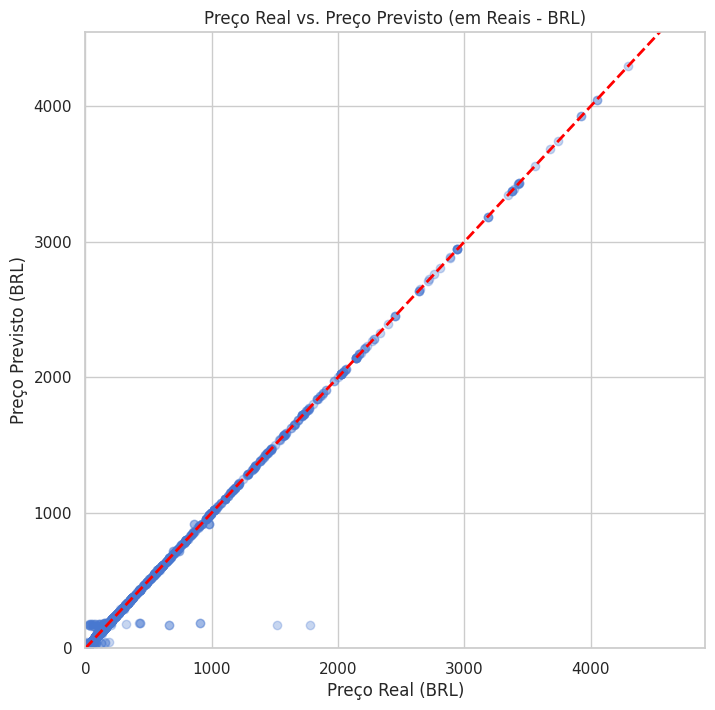

Gráfico ideal: Pontos concentrados ao redor da linha vermelha.


In [22]:
# ======================================================
# 9. Análise Visual dos Resultados
# ======================================================

plt.figure(figsize=(8, 8))
plt.scatter(y_test_brl, y_pred_brl, alpha=0.3)

max_val = max(y_test_brl.max(), y_pred_brl.max())
plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', linewidth=2)

plt.xlim(0, np.percentile(y_test_brl, 99))
plt.ylim(0, np.percentile(y_pred_brl, 99))

plt.title('Preço Real vs. Preço Previsto (em Reais - BRL)')
plt.xlabel('Preço Real (BRL)')
plt.ylabel('Preço Previsto (BRL)')
plt.grid(True)
plt.show()

print("Gráfico ideal: Pontos concentrados ao redor da linha vermelha.")

In [23]:
# ======================================================
# 10. Conclusões Iniciais
# ======================================================

print(f"""


1.  **Dados:** O dataset combinado é rico, mas "esparso" (muitos NaNs
    devido à combinação de categorias), exigindo tratamento cuidadoso.

2.  **EDA:** A análise exploratória confirmou que o preço (alvo) é
    altamente assimétrico. O uso da transformação logarítmica
    (diretamente no preço em BRL) foi essencial para normalizar
    a variável alvo.

3.  **Pré-processamento:** A estratégia de imputar NaNs numéricos com '0'
    (significando 'não aplicável') e categóricos com 'missing' foi
    bem-sucedida. A remoção de colunas de alta cardinalidade
    ('Name', 'Model') foi crucial.

4.  **Modelo Base (Regressão Linear):**
    * O modelo conseguiu aprender padrões gerais, alcançando um R² de {r2:.3f}
      (na escala log-BRL).
    * O erro médio (MAE) de R$ {mae_brl:.2f} mostra o desempenho em
      termos monetários. Dado o vasto range de preços (de mouses a
      placas de vídeo), esse valor é o nosso ponto de partida (baseline).
    * O gráfico de dispersão mostra que o modelo segue a tendência,
      mas tende a subestimar os preços de componentes muito caros.

""")




1.  **Dados:** O dataset combinado é rico, mas "esparso" (muitos NaNs
    devido à combinação de categorias), exigindo tratamento cuidadoso.

2.  **EDA:** A análise exploratória confirmou que o preço (alvo) é
    altamente assimétrico. O uso da transformação logarítmica
    (diretamente no preço em BRL) foi essencial para normalizar
    a variável alvo.

3.  **Pré-processamento:** A estratégia de imputar NaNs numéricos com '0'
    (significando 'não aplicável') e categóricos com 'missing' foi
    bem-sucedida. A remoção de colunas de alta cardinalidade
    ('Name', 'Model') foi crucial.

4.  **Modelo Base (Regressão Linear):**
    * O modelo conseguiu aprender padrões gerais, alcançando um R² de 0.978
      (na escala log-BRL).
    * O erro médio (MAE) de R$ 7.20 mostra o desempenho em
      termos monetários. Dado o vasto range de preços (de mouses a
      placas de vídeo), esse valor é o nosso ponto de partida (baseline).
    * O gráfico de dispersão mostra que o modelo segue a te